In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import matplotlib
import pandas as pd
import pylab
import scipy
pylab.rcParams['figure.figsize'] = (20, 10)

In [26]:
# Constants

satellite_sources = ["goes", "modis_terra", "modis_aqua"]
data_dir = os.path.expanduser("~/dados-ic/output")
path_list = {"goes": "goes.csv", "modis_terra": "modis_terra.csv", "modis_aqua": "modis_aqua.csv", "tsi": "tsi.csv", "rad": "rad.csv"}


cf_list = {"rad_long": "Long_SW_CloudFraction", "rad_xl": "XL_CloudFraction", "tsi": "TSI_CloudFraction", "goes": "CloudFraction_VIS",
           "modis_aqua": "Cloud_Fraction", "modis_terra": "Cloud_Fraction"}

In [27]:
source1 = "tsi"
source2 = "rad"

In [28]:
def load_datasets(name1, name2):
    
    if (name1 == name2):
        return
    
    if ("rad" in name1):
        name1 = "rad"
    elif ("rad" in name2):
        name2 = "rad"
    

    
    if (name1 not in satellite_sources) and (name2 not in satellite_sources):
        hasSat = False
        if (name1 == "tsi"):
            path = os.path.join(data_dir, path_list[name1][:-4] + "-centered-" + path_list[name2])
        else:
            path = os.path.join(data_dir, path_list[name2][:-4] + "-centered-" + path_list[name1])    
        ds = pd.read_csv(path, na_values=["--"], parse_dates=["Time"])
    else:
        hasSat = True
        
        _name1 = name1
        _name2 = name2
        
        if (_name1 not in satellite_sources):
            _name1 = name2
            _name2 = name1                 
        if (_name2 == "goes"):
            _name2 = _name1
            _name1 = "goes"
            
        path1 = os.path.join(data_dir, path_list[_name1])
        path2 = os.path.join(data_dir, path_list[_name2])
        path2 = path2[:-4] + "-centered-" + path_list[_name1]
        ds1 = pd.read_csv(path1, na_values=["--"], parse_dates=["Time"])
        ds2 = pd.read_csv(path2, na_values=["--"], parse_dates=["Time"])
        ds = pd.merge(ds1, ds2, on="Time", how="outer")
    
    return {"Dataset": ds, "hasSat": hasSat}


def analyze(dataset, name1, name2):
    ds = dataset["Dataset"]
    col1 = cf_list[name1]
    col2 = cf_list[name2]
    
    data3 = ds.copy()
    ind = np.isfinite(data3[col1])
    ind &= np.isfinite(data3[col2])
    data3 = data3[ind]
    
    if not dataset["hasSat"]:
        filter_col = "Timedelta"
        timedeltas = np.unique(data3.Timedelta)
        qtd_timedeltas = len(timedeltas)
        mtr = np.zeros((qtd_timedeltas))
        p_mtr = np.zeros((qtd_timedeltas))
        n_mtr = np.zeros((qtd_timedeltas))
        i = 0
        for timedelta in timedeltas:
            data4 = data3[data3[filter_col] == timedelta]
            y1 = data4[col1]
            y2 = data4[col2]

            inds = np.isfinite(y2)
            inds &= np.isfinite(y1)

            y1 = y1[inds]
            y2 = y2[inds]
            (r, p) = st.pearsonr(y1, y2)
            mtr[i] = r
            n_mtr[i] = len(y1)
            i += 1

        gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        
        ax1.plot(timedeltas / 60, mtr, 'o')
        ax1.set_title("Correlação entre %s e %s" % (col1, col2))
        ax1.set_xlabel("Tempo de amostragem (minutos)")
        ax1.set_ylabel("Coeficiente de correlação de Pearson")
    
        data3_hours = data3.Time.dt.hour
        ax2.hist(data3_hours, bins=24, range=(0, 24), label="Quantidade de combinações de dados")
        ax2.axvline(22, color='k', label="Intervalo entre 10h e 22h UTC")
        ax2.axvline(10, color='k')
        ax2.set_xlim((0, 24))
        ax2.set_title("Histograma das horas dos dados combinados")
        ax2.set_ylabel("Quantidade")
        ax2.set_xlabel("Horas (UTC)")
        ax2.legend()
        plt.show()
        
    else:
        delta_col = "Delta"
        filter_col = "Timedelta"

        fix_delta_goes = True
        delta_goes = 0.5

        # Filtrar NaNs
        y1 = data3[col1]
        y2 = data3[col2]
        inds = np.isfinite(y1)
        inds &= np.isfinite(y2)
        data3 = data3[inds]

        if (name1 == "goes"):
            delta_col = "Delta_x"
            if (fix_delta_goes is True):
                inds = data3["Delta_y"] == delta_goes
                data3 = data3[inds]

        timedeltas = sorted(np.unique(data3[filter_col]))
        deltas = sorted(np.unique(data3[delta_col]))

        qtd_deltas = len(deltas)
        qtd_timedeltas = len(timedeltas)

        mtr = np.zeros((qtd_timedeltas, qtd_deltas))
        p_mtr = np.zeros((qtd_timedeltas, qtd_deltas))
        n_mtr = np.zeros((qtd_timedeltas, qtd_deltas))
        i = 0
        j = 0
        for timedelta in timedeltas:
            for delta in deltas:

                data4 = data3[data3[delta_col] == delta]
                data4 = data4[data4[filter_col] == timedelta]
                y1 = data4[col1]
                y2 = data4[col2]

                inds = np.isfinite(y2)
                inds &= np.isfinite(y1)
                #inds &= y1 < 0.99
                #inds &= y2 < 0.99

                y1 = y1[inds]
                y2 = y2[inds]
                (r, p) = st.pearsonr(y1, y2)
                mtr[i, j] = r
                n_mtr[i, j] = len(y1)
                p_mtr[i, j] = p
                #mtr[i, j] = len(y1)
                j += 1
            j = 0
            i += 1
            
        gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
        plot_mtr = mtr
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        mp = ax1.matshow(plot_mtr, aspect="auto")
        ax1.set_xticks(np.arange(len(deltas)))
        ax1.set_xticklabels(deltas)
        ax1.set_yticks(np.arange(len(timedeltas)))
        ax1.set_yticklabels(np.array(timedeltas) / 60)
        ax1.set_xlabel("Tamanho da caixa espacial em graus")
        ax1.set_ylabel("Tamanho da caixa temporal em minutos")
        plt.colorbar(mp, label="Correlação", ax=ax1)
        ax1.set_title("Correlação entre %s e %s" % (col1, col2))
        for (i, j), z in np.ndenumerate(plot_mtr):
            ax1.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=10)
        data3_hours = data3.Time.dt.hour
        ax2.hist(data3_hours, bins=24, range=(0, 24), label="Quantidade de combinações de dados")
        ax2.axvline(22, color='k', label="Intervalo entre 10h e 22h UTC")
        ax2.axvline(10, color='k')
        ax2.set_xlim((0, 24))
        ax2.set_title("Histograma das horas dos dados combinados")
        ax2.set_ylabel("Quantidade")
        ax2.set_xlabel("Horas (UTC)")
        ax2.legend()
        plt.show()
    return mtr

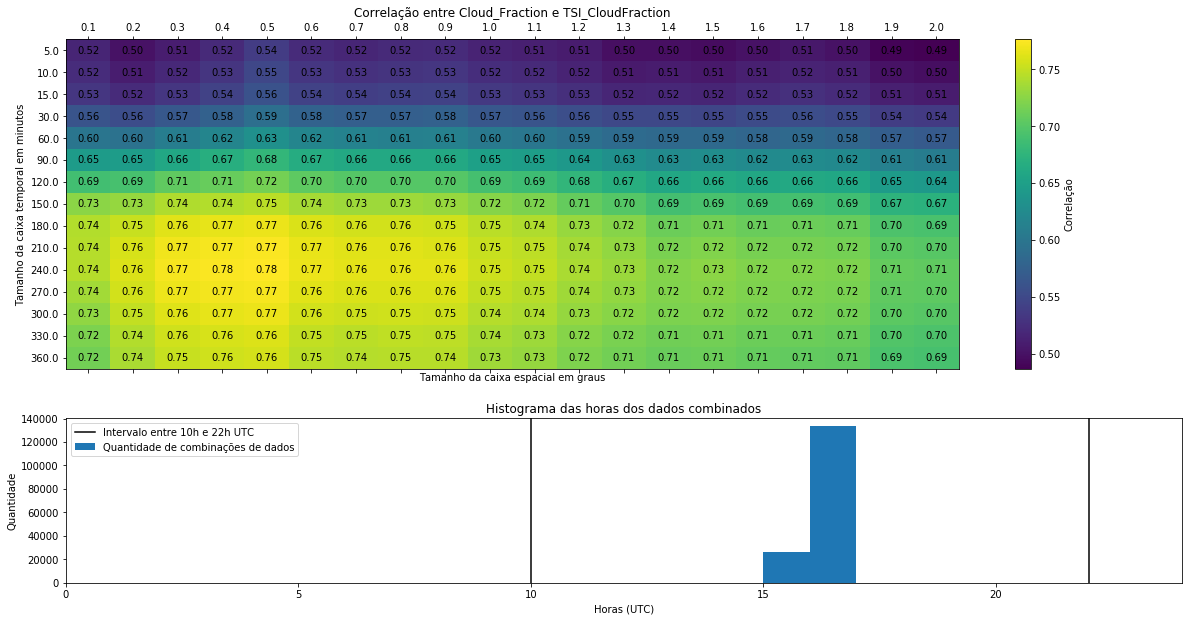

In [88]:
name1 = "modis_terra"
name2 = "tsi"

ds = load_datasets(name1, name2)

data = ds["Dataset"] 
ind1 = data.Time.dt.hour >= 15
ind1 &= data.Time.dt.hour < 17
ds["Dataset"] = data[ind1]

a = analyze(ds, name1, name2)

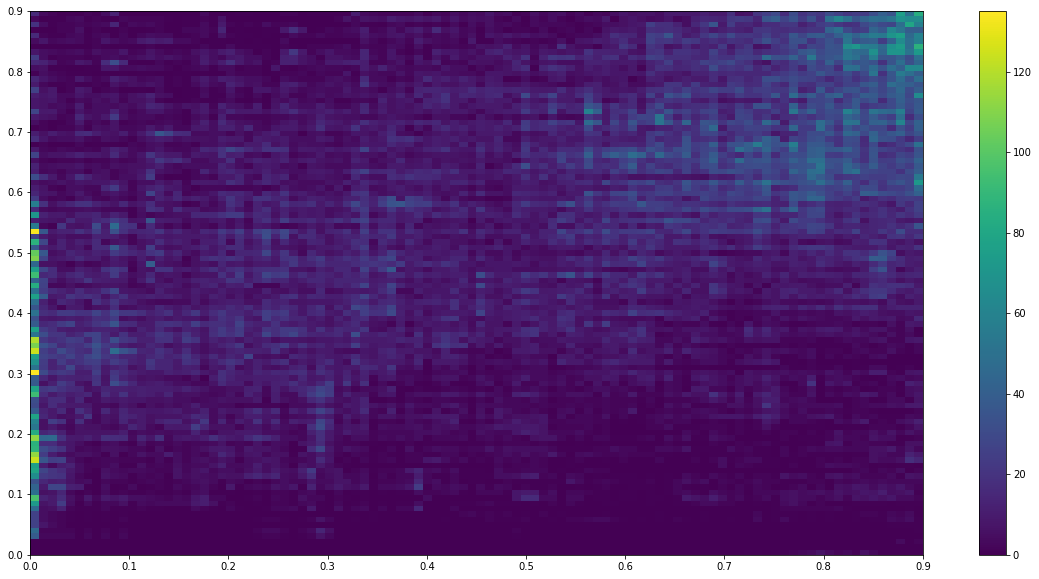

In [92]:
col1 = "Cloud_Fraction"
col2 = "TSI_CloudFraction"

inds = np.isfinite(data[col1])
inds &= np.isfinite(data[col2])
#inds &= data[col1] < 1
#inds &= data[col2] < 1
d = data[inds]

f = lambda x, a, b, c, d: a * x ** 2 + b * x + c + d * x ** 3

#out = scipy.optimize.curve_fit(f, d[col1], d[col2], p0=[0, 0, 0, 0])

#x = np.linspace(0, 1, 50)
#y = f(x, *out[0])
#plt.errorbar(x, y)
plt.hist2d(d[col1], d[col2], bins=100, range=((0, 0.9), (0, 0.9)))
plt.colorbar()

plt.show()

In [70]:
out[0]

array([-0.58218947,  1.46099988, -0.00647603])